# tutorial https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

## Note to Jose
Working version but not fully understood yet
The next commented think can allow to remove stuff

In [1]:
# Download TorchVision repo to use some files from
# references/detection
!git clone git@github.com:jcmayoral/PyTorch-YOLOv3.git yolov3

fatal: destination path 'yolov3' already exists and is not an empty directory.


In [2]:
from yolov3.models import Darknet

#model_4classes = Darknet(config_path="yolov3/config/yolov3-custom.cfg")

In [3]:
#nparams = sum(p.numel() for p in model_4classes.parameters())
#print (f"{nparams:,}")

In [4]:
!ls
!pwd

 __pycache__			   pointclouds-deeplearning.ipynb
'attempt yolo-binary.ipynb'	   pointnet.ipynb
'attempt yolo.ipynb'		   pypcd_hack
 checkpoints			   rcnntutorial.ipynb
 coco_eval.py			   runs
 coco_utils.py			   svmpersons.ipynb
 decisiontreepersons.ipynb	   testimageyolo.jpg
 engine.py			   testingyolo
 iros2021			   testingyolo2
 iros2021.ipynb			   transforms.py
 iros2021_depthversion.ipynb	   utils.py
 linearregressionpersons.ipynb	   vision
 logisticregressionpersons.ipynb   yolov3
 output
/home/jose/ros_ws/src/gr_perception/gr_ml/nb


In [5]:
bs = 16
nepochs = 50
ncpu = 6
gradient_accumulations = 2
evaluation_interval = 10
checkpoint_interval = 10
img_size = 416

In [6]:
from __future__ import division

from yolov3.models import *
from yolov3.utils.logger import *
from yolov3.utils.utils import *
from yolov3.utils.datasets import *
from yolov3.utils.parse_config import *
from yolov3.test import evaluate

from terminaltables import AsciiTable

import os
import sys
import time
import datetime
import argparse

import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.optim as optim


"""
parser.add_argument("--epochs", type=int, default=100, help="number of epochs")
parser.add_argument("--batch_size", type=int, default=8, help="size of each image batch")
parser.add_argument("--gradient_accumulations", type=int, default=2, help="number of gradient accums before step")
parser.add_argument("--model_def", type=str, default="config/yolov3.cfg", help="path to model definition file")
parser.add_argument("--data_config", type=str, default="config/coco.data", help="path to data config file")
parser.add_argument("--pretrained_weights", type=str, help="if specified starts from checkpoint model")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--img_size", type=int, default=416, help="size of each image dimension")
parser.add_argument("--checkpoint_interval", type=int, default=1, help="interval between saving model weights")
parser.add_argument("--evaluation_interval", type=int, default=1, help="interval evaluations on validation set")
parser.add_argument("--compute_map", default=False, help="if True computes mAP every tenth batch")
parser.add_argument("--multiscale_training", default=True, help="allow for multi-scale training")
opt = parser.parse_args()
print(opt)
"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.makedirs("output", exist_ok=True)
os.makedirs("checkpoints", exist_ok=True)

# Get data configuration
data_config = parse_data_config("yolov3/config/iros2021.data")
#data_config = { line.split()[0] : line.split()[1] for line in open("yolov3/config/jose.data") }

#parse_data_config(opt.data_config)bb
train_path = data_config["train"]
valid_path = data_config["valid"]
class_names = load_classes(data_config["names"])

print(class_names)

# Initiate model
model = Darknet("yolov3/config/iros2021-tiny.cfg").to(device)#, img_size=img_size).to(device)
model.apply(weights_init_normal)

# If specified we start from checkpoint





/home/jose/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jose/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jose/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jose/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWa

['ring0', 'ring1', 'ring2', 'ring3']


Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(16, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (maxpool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (conv_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1)
    )
    (3): Sequential(
      (maxpool_3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (4): Sequential(
      (conv_4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_4): BatchNorm2d(64, eps=1e-05, momentum=0.9, aff

In [7]:
#model.load_state_dict(torch.load("/home/jose/ros_ws/src/gr_perception/gr_ml/nb/testingyolo/checkpoints/yolov3_v2_ckpt_140.pth"))

In [8]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/yolo_rgb')
plot_interval = 100

In [9]:
# Get dataloader
#For some reason augment or multiscale fails
dataset = ListDataset(train_path, augment=True, multiscale=True)
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=bs,
    shuffle=True,
    num_workers=ncpu,
    pin_memory=False,
    collate_fn=dataset.collate_fn,
)

optimizer = torch.optim.Adam(model.parameters())

metrics = [
    "grid_size",
    "loss",
    "x",
    "y",
    "w",
    "h",
    "conf",
    "cls",
    "cls_acc",
    "recall50",
    "recall75",
    "precision",
    "conf_obj",
    "conf_noobj",
]

try:
    os.makedirs("testingyolo2")
except:
    pass

#logger = Logger("testingyolo/logs")


for epoch in range(nepochs):
    model.train()
    start_time = time.time()
    epoch_loss = 0.0

    for batch_i, (_, imgs, targets) in enumerate(dataloader):
        #print(_)0
        batches_done = len(dataloader) * epoch + batch_i

        imgs = Variable(imgs.to(device))
        targets = Variable(targets.to(device), requires_grad=False)

        loss, outputs = model(imgs, targets)
        loss.backward()
        
        epoch_loss += outputs.shape[0] * loss.item()

        writer.add_scalar('Loss/train_batch', loss,(epoch*len(dataloader)+batch_i))

        if batches_done % gradient_accumulations:
            # Accumulates gradient before each step
            optimizer.step()
            optimizer.zero_grad()

        # ----------------
        #   Log progress
        # ----------------
        yololoss = [yolo.metrics["loss"] for yolo in model.yolo_layers]
        for i, yloss in enumerate(yololoss):
            writer.add_scalar('Loss/yolo_loss'+str(i), yloss,(epoch*len(dataloader)+batch_i))
        #writer.add_scalar('Loss/yolo_loss1', yololoss[1],(epoch*len(dataloader)+batch_i))
        #writer.add_scalar('Loss/yolo_loss2', yololoss[2],(epoch*len(dataloader)+batch_i))

        log_str = "\n---- [Epoch %d/%d, Batch %d/%d] ----\n" % (epoch, nepochs, batch_i, len(dataloader))

        metric_table = [["Metrics", *[f"YOLO Layer {i}" for i in range(len(model.yolo_layers))]]]

        if batch_i % plot_interval == 0:
            # Log metrics at each YOLO layer
            for i, metric in enumerate(metrics):
                formats = {m: "%.6f" for m in metrics}
                formats["grid_size"] = "%2d"
                formats["cls_acc"] = "%.2f%%"
                row_metrics = [formats[metric] % yolo.metrics.get(metric, 0) for yolo in model.yolo_layers]
                metric_table += [[metric, *row_metrics]]

                # Tensorboard logging
                """
                tensorboard_log = []
                for j, yolo in enumerate(model.yolo_layers):
                    for name, metric in yolo.metrics.items():
                        if name != "grid_size":
                            tensorboard_log += [(f"{name}_{j+1}", metric)]
                tensorboard_log += [("loss", loss.item())]
                """
                #logger.list_of_scalars_summary(tensorboard_log, batches_done)

            log_str += AsciiTable(metric_table).table
            log_str += f"\nTotal loss {loss.item()}"

            # Determine approximate time left for epoch
            epoch_batches_left = len(dataloader) - (batch_i + 1)
            time_left = datetime.timedelta(seconds=epoch_batches_left * (time.time() - start_time) / (batch_i + 1))
            log_str += f"\n---- ETA {time_left}"

            print(log_str)
            #break

        model.seen += imgs.size(0)
    
    
    writer.add_scalar('Loss/train_epoch', epoch_loss / len(dataloader), epoch)
    #print ("HERE", len(dataloader), epoch_loss)


    if epoch % evaluation_interval == 0:
        print(log_str)
        print("\n---- Evaluating Model ----")
        # Evaluate the model on the validation set
        eval_results = evaluate(
            model,
            path=valid_path,
            iou_thres=0.5,
            conf_thres=0.5,
            nms_thres=0.5,
            img_size=img_size,
            batch_size=1,
        )
        
        if eval_results is not None:
            precision, recall, AP, f1, ap_class = eval_results
            """
            evaluation_metrics = [
                ("val_precision", precision.mean()),
                ("val_recall", recall.mean()),
                ("val_mAP", AP.mean()),
                ("val_f1", f1.mean()),
            ]
            logger.list_of_scalars_summary(evaluation_metrics, epoch)
            """
            # Print class APs and mAP
            ap_table = [["Index", "Class name", "AP"]]
            for i, c in enumerate(ap_class):
                ap_table += [[c, class_names[c], "%.5f" % AP[i]]]
            print(AsciiTable(ap_table).table)
            print(f"---- mAP {AP.mean()}")
            writer.add_scalar('metrics/map_eval', AP.mean(), int(epoch / evaluation_interval))
            writer.add_scalar('metrics/precision', precision.mean(), int(epoch / evaluation_interval))
            writer.add_scalar('metrics/recall', recall.mean(), int(epoch / evaluation_interval))
            writer.add_scalar('metrics/f1', f1.mean(), int(epoch / evaluation_interval))


    if epoch % checkpoint_interval == 0:
        print (log_str)
        torch.save(model.state_dict(), f"testingyolo/checkpoints/yolov3_v2_ckpt_%d.pth" % epoch)



---- [Epoch 0/50, Batch 0/250] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 73.793518    | 75.919792    |
| x          | 0.097596     | 0.126384     |
| y          | 0.060810     | 0.211024     |
| w          | 0.601752     | 0.909861     |
| h          | 0.452935     | 0.832950     |
| conf       | 71.786583    | 73.088730    |
| cls        | 0.793841     | 0.750843     |
| cls_acc    | 0.00%        | 0.00%        |
| recall50   | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     |
| conf_obj   | 0.420391     | 0.578171     |
| conf_noobj | 0.502835     | 0.512532     |
+------------+--------------+--------------+
Total loss 149.71331787109375
---- ETA 0:06:51.646956

---- [Epoch 0/50, Batch 100/250] ----
+------------+--------------+--------------+
| Metrics    | 

Detecting objects:   0%|          | 0/400 [00:00<?, ?it/s]


---- [Epoch 0/50, Batch 249/250] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 1268.02it/s]


+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.41366 |
| 1     | ring1      | 0.47263 |
| 2     | ring2      | 0.54902 |
| 3     | ring3      | 0.44936 |
+-------+------------+---------+
---- mAP 0.47117039171611963

---- [Epoch 0/50, Batch 249/250] ----


---- [Epoch 1/50, Batch 0/250] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 16           | 32           |
| loss       | 0.930894     | 1.282476     |
| x          | 0.007098     | 0.032119     |
| y          | 0.008166     | 0.012087     |
| w          | 0.052156     | 0.082879     |
| h          | 0.131338     | 0.035561     |
| conf       | 0.715780     | 1.103481     |
| cls        | 0.016356     | 0.016349     |
| cls_acc    | 75.00%       | 81.25%       |
| recall50   | 0.625000     | 0.812500     |
| recall75   | 0.187500     | 0.750000     |



---- [Epoch 4/50, Batch 0/250] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 16           | 32           |
| loss       | 0.814582     | 0.564540     |
| x          | 0.020839     | 0.025133     |
| y          | 0.002135     | 0.013427     |
| w          | 0.057663     | 0.023745     |
| h          | 0.103925     | 0.008022     |
| conf       | 0.605773     | 0.484347     |
| cls        | 0.024247     | 0.009868     |
| cls_acc    | 43.75%       | 93.75%       |
| recall50   | 0.375000     | 0.875000     |
| recall75   | 0.062500     | 0.750000     |
| precision  | 0.240000     | 0.297872     |
| conf_obj   | 0.810291     | 0.852947     |
| conf_noobj | 0.001890     | 0.001794     |
+------------+--------------+--------------+
Total loss 1.3791224956512451
---- ETA 0:05:12.401705

---- [Epoch 4/50, Batch 100/250] ----
+------------+--------------+--------------+
| Metrics    | 


---- [Epoch 7/50, Batch 100/250] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 11           | 22           |
| loss       | 0.127216     | 0.300491     |
| x          | 0.008944     | 0.019134     |
| y          | 0.001887     | 0.001522     |
| w          | 0.015345     | 0.008269     |
| h          | 0.005397     | 0.004893     |
| conf       | 0.085589     | 0.257607     |
| cls        | 0.010053     | 0.009065     |
| cls_acc    | 87.50%       | 81.25%       |
| recall50   | 0.875000     | 0.812500     |
| recall75   | 0.875000     | 0.812500     |
| precision  | 0.823529     | 0.464286     |
| conf_obj   | 0.981709     | 0.917429     |
| conf_noobj | 0.000517     | 0.001052     |
+------------+--------------+--------------+
Total loss 0.42770737409591675
---- ETA 0:00:49.491633

---- [Epoch 7/50, Batch 200/250] ----
+------------+--------------+--------------+
| Metrics   


---- [Epoch 10/50, Batch 200/250] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 14           | 28           |
| loss       | 0.482555     | 0.326545     |
| x          | 0.005583     | 0.006636     |
| y          | 0.003068     | 0.006508     |
| w          | 0.006884     | 0.003930     |
| h          | 0.009870     | 0.004885     |
| conf       | 0.445265     | 0.294808     |
| cls        | 0.011886     | 0.009778     |
| cls_acc    | 68.75%       | 81.25%       |
| recall50   | 0.625000     | 0.750000     |
| recall75   | 0.625000     | 0.750000     |
| precision  | 0.454545     | 0.342857     |
| conf_obj   | 0.907869     | 0.919233     |
| conf_noobj | 0.001116     | 0.000934     |
+------------+--------------+--------------+
Total loss 0.8091006278991699
---- ETA 0:00:16.554785


Detecting objects:   0%|          | 0/400 [00:00<?, ?it/s]


---- [Epoch 10/50, Batch 249/250] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 3004.52it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.66496 |
| 1     | ring1      | 0.70145 |
| 2     | ring2      | 0.82567 |
| 3     | ring3      | 0.90838 |
+-------+------------+---------+
---- mAP 0.7751154305362655

---- [Epoch 10/50, Batch 249/250] ----




---- [Epoch 11/50, Batch 0/250] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 15           | 30           |
| loss       | 0.238852     | 0.245908     |
| x          | 0.003169     | 0.006743     |
| y          | 0.006588     | 0.004801     |
| w          | 0.014878     | 0.005542     |
| h          | 0.006249     | 0.003901     |
| conf       | 0.201990     | 0.217187     |
| cls        | 0.005978     | 0.007735     |
| cls_acc    | 93.75%       | 93.75%       |
| recall50   | 0.937500     | 0.937500     |
| recall75   | 0.937500     | 0.937500     |
| precision  | 0.714286     | 0.333333     |
| conf_obj   | 0.939184     | 0.955269     |
| conf_noobj | 0.000824     | 0.000947     |
+------------+--------------+--------------+
Total loss 0.484760582447052
---- ETA 0:05:04.868546

---- [Epoch 11/50, Batch 100/250] ----
+------------+--------------+--------------+
| Metrics    |


---- [Epoch 14/50, Batch 100/250] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 0.151072     | 0.212668     |
| x          | 0.006914     | 0.005427     |
| y          | 0.014256     | 0.005908     |
| w          | 0.007588     | 0.005055     |
| h          | 0.004219     | 0.001816     |
| conf       | 0.106452     | 0.183784     |
| cls        | 0.011643     | 0.010678     |
| cls_acc    | 75.00%       | 87.50%       |
| recall50   | 0.750000     | 0.875000     |
| recall75   | 0.750000     | 0.875000     |
| precision  | 0.666667     | 0.424242     |
| conf_obj   | 0.979477     | 0.956512     |
| conf_noobj | 0.000624     | 0.000811     |
+------------+--------------+--------------+
Total loss 0.36374005675315857
---- ETA 0:00:46.813386

---- [Epoch 14/50, Batch 200/250] ----
+------------+--------------+--------------+
| Metrics 


---- [Epoch 17/50, Batch 200/250] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 10           | 20           |
| loss       | 0.454876     | 0.482798     |
| x          | 0.005298     | 0.006891     |
| y          | 0.003557     | 0.001552     |
| w          | 0.006664     | 0.004174     |
| h          | 0.017751     | 0.002877     |
| conf       | 0.410438     | 0.454645     |
| cls        | 0.011168     | 0.012658     |
| cls_acc    | 81.25%       | 75.00%       |
| recall50   | 0.812500     | 0.687500     |
| recall75   | 0.812500     | 0.687500     |
| precision  | 0.619048     | 0.282051     |
| conf_obj   | 0.903250     | 0.870643     |
| conf_noobj | 0.001617     | 0.001402     |
+------------+--------------+--------------+
Total loss 0.9376746416091919
---- ETA 0:00:17.233733

---- [Epoch 18/50, Batch 0/250] ----
+------------+--------------+--------------+
| Metrics    

Detecting objects:   0%|          | 0/400 [00:00<?, ?it/s]


---- [Epoch 20/50, Batch 249/250] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 3078.39it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.48758 |
| 1     | ring1      | 0.66773 |
| 2     | ring2      | 0.71904 |
| 3     | ring3      | 0.82544 |
+-------+------------+---------+
---- mAP 0.6749471921929074

---- [Epoch 20/50, Batch 249/250] ----




---- [Epoch 21/50, Batch 0/250] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 15           | 30           |
| loss       | 0.205001     | 0.369330     |
| x          | 0.007882     | 0.022112     |
| y          | 0.008064     | 0.010491     |
| w          | 0.020193     | 0.011860     |
| h          | 0.004984     | 0.022670     |
| conf       | 0.151264     | 0.290533     |
| cls        | 0.012614     | 0.011662     |
| cls_acc    | 75.00%       | 75.00%       |
| recall50   | 0.687500     | 0.750000     |
| recall75   | 0.687500     | 0.687500     |
| precision  | 0.550000     | 0.279070     |
| conf_obj   | 0.942110     | 0.912937     |
| conf_noobj | 0.000503     | 0.000819     |
+------------+--------------+--------------+
Total loss 0.5743309259414673
---- ETA 0:05:05.758268

---- [Epoch 21/50, Batch 100/250] ----
+------------+--------------+--------------+
| Metrics    


---- [Epoch 24/50, Batch 100/250] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 16           | 32           |
| loss       | 0.651072     | 0.556570     |
| x          | 0.011244     | 0.018299     |
| y          | 0.004163     | 0.005206     |
| w          | 0.058372     | 0.011948     |
| h          | 0.152140     | 0.004413     |
| conf       | 0.411995     | 0.506624     |
| cls        | 0.013157     | 0.010080     |
| cls_acc    | 61.11%       | 83.33%       |
| recall50   | 0.555556     | 0.722222     |
| recall75   | 0.555556     | 0.666667     |
| precision  | 0.555556     | 0.448276     |
| conf_obj   | 0.880042     | 0.875757     |
| conf_noobj | 0.000367     | 0.000445     |
+------------+--------------+--------------+
Total loss 1.2076417207717896
---- ETA 0:00:52.374699

---- [Epoch 24/50, Batch 200/250] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 27/50, Batch 200/250] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 15           | 30           |
| loss       | 0.217786     | 0.275260     |
| x          | 0.002805     | 0.008919     |
| y          | 0.007015     | 0.003805     |
| w          | 0.012570     | 0.007342     |
| h          | 0.016209     | 0.002992     |
| conf       | 0.169826     | 0.245565     |
| cls        | 0.009360     | 0.006638     |
| cls_acc    | 87.50%       | 93.75%       |
| recall50   | 0.875000     | 0.937500     |
| recall75   | 0.750000     | 0.937500     |
| precision  | 0.636364     | 0.333333     |
| conf_obj   | 0.965545     | 0.934274     |
| conf_noobj | 0.000722     | 0.000893     |
+------------+--------------+--------------+
Total loss 0.4930458068847656
---- ETA 0:00:15.534407

---- [Epoch 28/50, Batch 0/250] ----
+------------+--------------+--------------+
| Metrics    

Detecting objects:   0%|          | 0/400 [00:00<?, ?it/s]


---- [Epoch 30/50, Batch 249/250] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 3053.73it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.56827 |
| 1     | ring1      | 0.59693 |
| 2     | ring2      | 0.79113 |
| 3     | ring3      | 0.94204 |
+-------+------------+---------+
---- mAP 0.7245909177396326

---- [Epoch 30/50, Batch 249/250] ----




---- [Epoch 31/50, Batch 0/250] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 11           | 22           |
| loss       | 0.155462     | 0.243046     |
| x          | 0.011099     | 0.011388     |
| y          | 0.007615     | 0.005181     |
| w          | 0.009686     | 0.004890     |
| h          | 0.006385     | 0.002588     |
| conf       | 0.115113     | 0.214212     |
| cls        | 0.005564     | 0.004787     |
| cls_acc    | 93.75%       | 93.75%       |
| recall50   | 0.937500     | 0.937500     |
| recall75   | 0.875000     | 0.937500     |
| precision  | 0.833333     | 0.454545     |
| conf_obj   | 0.973055     | 0.943477     |
| conf_noobj | 0.000603     | 0.000855     |
+------------+--------------+--------------+
Total loss 0.39850813150405884
---- ETA 0:04:15.039504

---- [Epoch 31/50, Batch 100/250] ----
+------------+--------------+--------------+
| Metrics   


---- [Epoch 34/50, Batch 100/250] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 15           | 30           |
| loss       | 0.528858     | 0.418614     |
| x          | 0.008358     | 0.023587     |
| y          | 0.001059     | 0.004136     |
| w          | 0.018811     | 0.003580     |
| h          | 0.025695     | 0.006509     |
| conf       | 0.468049     | 0.374853     |
| cls        | 0.006886     | 0.005951     |
| cls_acc    | 87.50%       | 93.75%       |
| recall50   | 0.875000     | 0.937500     |
| recall75   | 0.875000     | 0.875000     |
| precision  | 0.777778     | 0.500000     |
| conf_obj   | 0.911429     | 0.914102     |
| conf_noobj | 0.000577     | 0.000615     |
+------------+--------------+--------------+
Total loss 0.9474726915359497
---- ETA 0:00:48.312929

---- [Epoch 34/50, Batch 200/250] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 37/50, Batch 200/250] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 0.910133     | 1.023082     |
| x          | 0.022935     | 0.006541     |
| y          | 0.003639     | 0.004382     |
| w          | 0.058524     | 0.045679     |
| h          | 0.016886     | 0.022996     |
| conf       | 0.803401     | 0.937457     |
| cls        | 0.004750     | 0.006026     |
| cls_acc    | 87.50%       | 81.25%       |
| recall50   | 0.812500     | 0.812500     |
| recall75   | 0.812500     | 0.750000     |
| precision  | 0.722222     | 0.433333     |
| conf_obj   | 0.866531     | 0.847810     |
| conf_noobj | 0.000462     | 0.000636     |
+------------+--------------+--------------+
Total loss 1.9332149028778076
---- ETA 0:00:15.148774

---- [Epoch 38/50, Batch 0/250] ----
+------------+--------------+--------------+
| Metrics    

Detecting objects:   0%|          | 0/400 [00:00<?, ?it/s]


---- [Epoch 40/50, Batch 249/250] ----


---- Evaluating Model ----


Computing AP: 100%|██████████| 4/4 [00:00<00:00, 2399.49it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | ring0      | 0.63844 |
| 1     | ring1      | 0.66835 |
| 2     | ring2      | 0.68147 |
| 3     | ring3      | 0.82289 |
+-------+------------+---------+
---- mAP 0.7027872552859501

---- [Epoch 40/50, Batch 249/250] ----




---- [Epoch 41/50, Batch 0/250] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 15           | 30           |
| loss       | 0.115522     | 0.170358     |
| x          | 0.004438     | 0.004857     |
| y          | 0.002781     | 0.002566     |
| w          | 0.013839     | 0.009551     |
| h          | 0.005633     | 0.002165     |
| conf       | 0.081520     | 0.147426     |
| cls        | 0.007311     | 0.003794     |
| cls_acc    | 87.50%       | 93.75%       |
| recall50   | 0.875000     | 0.937500     |
| recall75   | 0.875000     | 0.937500     |
| precision  | 0.777778     | 0.468750     |
| conf_obj   | 0.985283     | 0.949765     |
| conf_noobj | 0.000439     | 0.000529     |
+------------+--------------+--------------+
Total loss 0.28588029742240906
---- ETA 0:04:59.580381

---- [Epoch 41/50, Batch 100/250] ----
+------------+--------------+--------------+
| Metrics   


---- [Epoch 44/50, Batch 100/250] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 12           | 24           |
| loss       | 0.532740     | 0.153917     |
| x          | 0.007551     | 0.014537     |
| y          | 0.003292     | 0.001635     |
| w          | 0.099881     | 0.013643     |
| h          | 0.225126     | 0.004398     |
| conf       | 0.190119     | 0.115493     |
| cls        | 0.006771     | 0.004212     |
| cls_acc    | 87.50%       | 100.00%      |
| recall50   | 0.812500     | 1.000000     |
| recall75   | 0.812500     | 0.941176     |
| precision  | 0.684211     | 0.680000     |
| conf_obj   | 0.944842     | 0.973739     |
| conf_noobj | 0.000693     | 0.000531     |
+------------+--------------+--------------+
Total loss 0.6866567134857178
---- ETA 0:00:51.445446

---- [Epoch 44/50, Batch 200/250] ----
+------------+--------------+--------------+
| Metrics  


---- [Epoch 47/50, Batch 200/250] ----
+------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 |
+------------+--------------+--------------+
| grid_size  | 13           | 26           |
| loss       | 1.167923     | 0.506357     |
| x          | 0.016621     | 0.014731     |
| y          | 0.006282     | 0.006312     |
| w          | 0.172164     | 0.004589     |
| h          | 0.374106     | 0.005930     |
| conf       | 0.594056     | 0.467743     |
| cls        | 0.004695     | 0.007050     |
| cls_acc    | 100.00%      | 82.35%       |
| recall50   | 0.812500     | 0.705882     |
| recall75   | 0.750000     | 0.705882     |
| precision  | 0.722222     | 0.428571     |
| conf_obj   | 0.860623     | 0.846747     |
| conf_noobj | 0.000679     | 0.000690     |
+------------+--------------+--------------+
Total loss 1.674280047416687
---- ETA 0:00:15.744818

---- [Epoch 48/50, Batch 0/250] ----
+------------+--------------+--------------+
| Metrics    |

In [10]:
def get_image_iteration(myiter):
    return next(myiter)

In [11]:
labels=[]

In [12]:
conf_thres = 0.9
nms_thres = 0.9

In [13]:
def evaluate(b):
    model.eval()
    with torch.no_grad():
        outputs = model(b.to(device))
        outputs = non_max_suppression(outputs, conf_thres=conf_thres, nms_thres=nms_thres)
    return outputs

In [14]:
from matplotlib.ticker import NullLocator

cmap = plt.get_cmap("tab20b")
colors = [cmap(i) for i in np.linspace(0, 1, 20)]


In [20]:
def plot_results(index):
    myiter = iter(dataloader)
    a,b,c = get_image_iteration(myiter)
    outputs = evaluate(b)
    # Iterate through images and save plot of detections
    for img_i, (image, detections) in enumerate(zip(b, outputs)):
        print("(%d) Image" % (img_i))

        # Create plot
        #img = np.array(Image.open(path))
        img = image.mul(255).permute(1, 2, 0).byte().cpu().numpy()
        plt.figure()
        fig, ax = plt.subplots(1)
        ax.imshow(img)

        # Draw bounding boxes and labels of detections
        if detections is not None:
            # Rescale boxes to oripginal image
            detections = rescale_boxes(detections, img_size, img.shape[:2])
            unique_labels = detections[:, -1].cpu().unique()
            n_cls_preds = len(unique_labels)
            bbox_colors = random.sample(colors, n_cls_preds)
            for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:

                print("\t+ Label: %s, Conf: %.5f" % (class_names[int(cls_pred)], cls_conf.item()))

                box_w = x2 - x1
                box_h = y2 - y1

                if cls_conf.item()<0.7:
                    continue



                color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
                # Create a Rectangle patch
                bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor="none")
                # Add the bbox to the plot
                ax.add_patch(bbox)
                # Add label
                plt.text(
                    x1,
                    y1,
                    s=class_names[int(cls_pred)]+" {:.1f}".format(cls_conf.item()),
                    color="white",
                    verticalalignment="top",
                    bbox={"color": color, "pad": 0},
                )

        plt.axis("off")
        plt.gca().xaxis.set_major_locator(NullLocator())
        plt.gca().yaxis.set_major_locator(NullLocator())
        plt.savefig("output/example_yolo{}_{}.png".format(str(img_i), str(index)), bbox_inches="tight", pad_inches=0.0,dpi=250)
        plt.show()
        plt.close()

(0) Image
	+ Label: ring3, Conf: 0.99698
	+ Label: ring3, Conf: 0.99685


<Figure size 432x288 with 0 Axes>

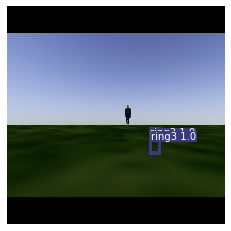

(1) Image
	+ Label: ring1, Conf: 0.85136
	+ Label: ring2, Conf: 0.63112


<Figure size 432x288 with 0 Axes>

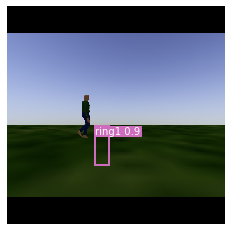

(2) Image
	+ Label: ring3, Conf: 0.96951
	+ Label: ring3, Conf: 0.93447


<Figure size 432x288 with 0 Axes>

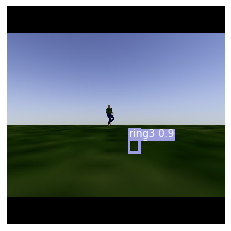

(3) Image
	+ Label: ring3, Conf: 0.81210
	+ Label: ring3, Conf: 0.79314


<Figure size 432x288 with 0 Axes>

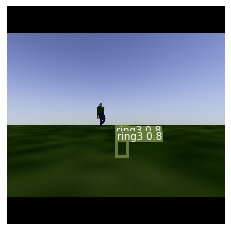

(4) Image
	+ Label: ring0, Conf: 0.88315
	+ Label: ring0, Conf: 0.81756


<Figure size 432x288 with 0 Axes>

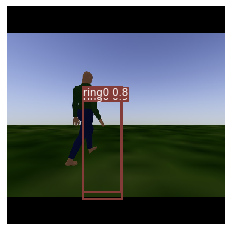

(5) Image
	+ Label: ring2, Conf: 0.94965
	+ Label: ring2, Conf: 0.94930


<Figure size 432x288 with 0 Axes>

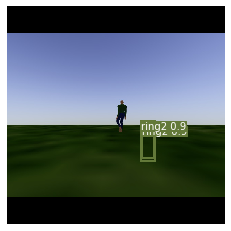

(6) Image
	+ Label: ring2, Conf: 0.93801
	+ Label: ring2, Conf: 0.71846


<Figure size 432x288 with 0 Axes>

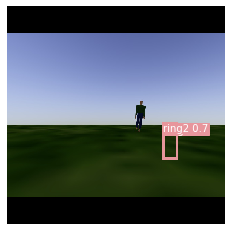

(7) Image
	+ Label: ring1, Conf: 0.80381
	+ Label: ring1, Conf: 0.79850


<Figure size 432x288 with 0 Axes>

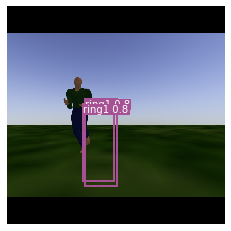

(8) Image
	+ Label: ring3, Conf: 0.97897
	+ Label: ring3, Conf: 0.91402


<Figure size 432x288 with 0 Axes>

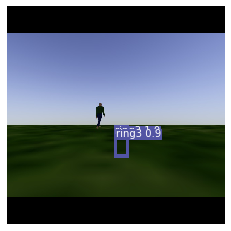

(9) Image
	+ Label: ring2, Conf: 0.87351
	+ Label: ring1, Conf: 0.75768


<Figure size 432x288 with 0 Axes>

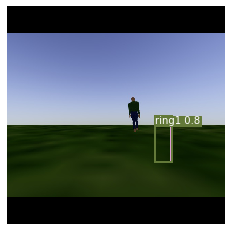

(10) Image
	+ Label: ring3, Conf: 0.61763
	+ Label: ring3, Conf: 0.42898


<Figure size 432x288 with 0 Axes>

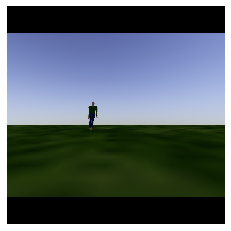

(11) Image
	+ Label: ring3, Conf: 0.82190
	+ Label: ring3, Conf: 0.73232


<Figure size 432x288 with 0 Axes>

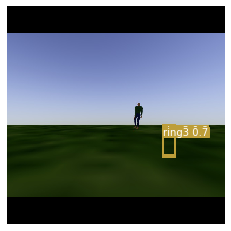

(12) Image
	+ Label: ring3, Conf: 0.89578
	+ Label: ring3, Conf: 0.63980


<Figure size 432x288 with 0 Axes>

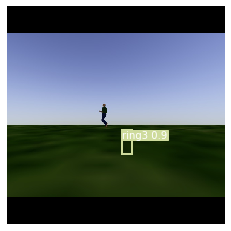

(13) Image
	+ Label: ring1, Conf: 0.70402


<Figure size 432x288 with 0 Axes>

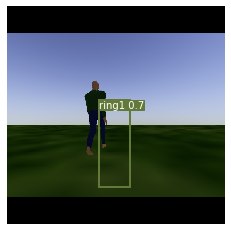

(14) Image
	+ Label: ring3, Conf: 0.73770
	+ Label: ring3, Conf: 0.47852


<Figure size 432x288 with 0 Axes>

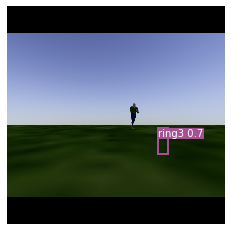

(15) Image
	+ Label: ring2, Conf: 0.90992
	+ Label: ring2, Conf: 0.80476


<Figure size 432x288 with 0 Axes>

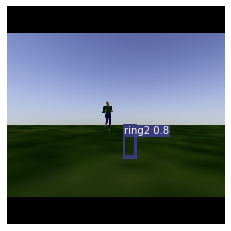

(0) Image
	+ Label: ring3, Conf: 0.99468
	+ Label: ring3, Conf: 0.99207


<Figure size 432x288 with 0 Axes>

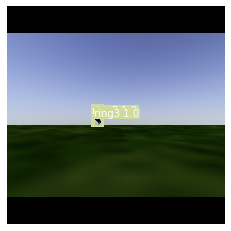

(1) Image
	+ Label: ring2, Conf: 0.91421


<Figure size 432x288 with 0 Axes>

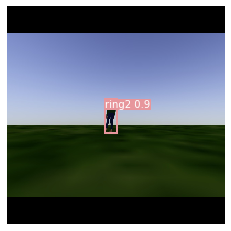

(2) Image
	+ Label: ring3, Conf: 0.92393
	+ Label: ring3, Conf: 0.59575


<Figure size 432x288 with 0 Axes>

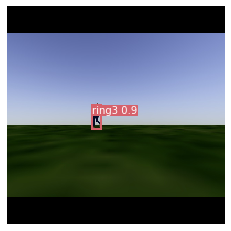

(3) Image
	+ Label: ring2, Conf: 0.98938


<Figure size 432x288 with 0 Axes>

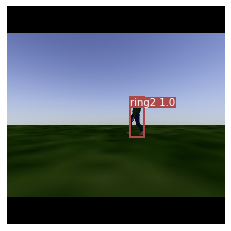

(4) Image
	+ Label: ring1, Conf: 0.98580


<Figure size 432x288 with 0 Axes>

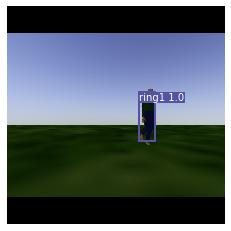

(5) Image
	+ Label: ring3, Conf: 0.62625
	+ Label: ring2, Conf: 0.41812


<Figure size 432x288 with 0 Axes>

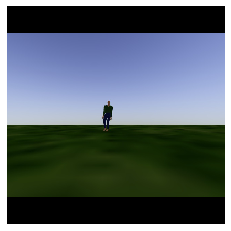

(6) Image
	+ Label: ring3, Conf: 0.98258
	+ Label: ring3, Conf: 0.98880


<Figure size 432x288 with 0 Axes>

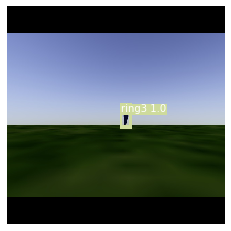

(7) Image
	+ Label: ring3, Conf: 0.99703
	+ Label: ring3, Conf: 0.99572


<Figure size 432x288 with 0 Axes>

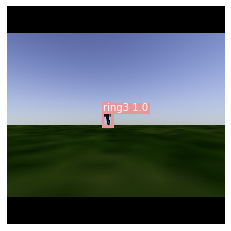

(8) Image
	+ Label: ring1, Conf: 0.99464


<Figure size 432x288 with 0 Axes>

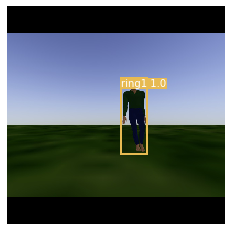

(9) Image
	+ Label: ring2, Conf: 0.99305


<Figure size 432x288 with 0 Axes>

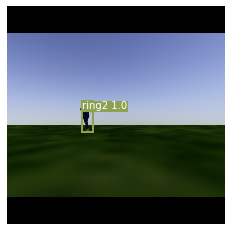

(10) Image
	+ Label: ring2, Conf: 0.91397


<Figure size 432x288 with 0 Axes>

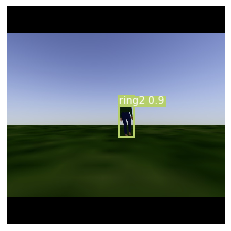

(11) Image
	+ Label: ring3, Conf: 0.99358
	+ Label: ring3, Conf: 0.99935


<Figure size 432x288 with 0 Axes>

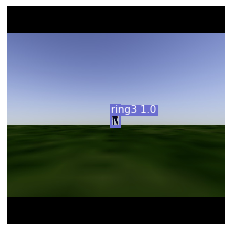

(12) Image
	+ Label: ring3, Conf: 0.98401
	+ Label: ring3, Conf: 0.96906
	+ Label: ring3, Conf: 0.97267


<Figure size 432x288 with 0 Axes>

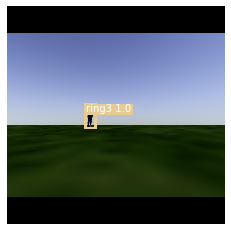

(13) Image
	+ Label: ring2, Conf: 0.84958
	+ Label: ring2, Conf: 0.57342


<Figure size 432x288 with 0 Axes>

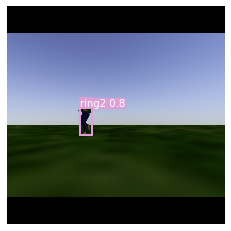

(14) Image
	+ Label: ring2, Conf: 0.98278
	+ Label: ring2, Conf: 0.98059


<Figure size 432x288 with 0 Axes>

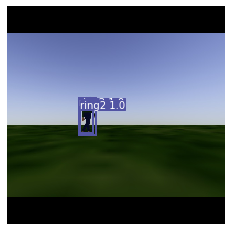

(15) Image
	+ Label: ring3, Conf: 0.93689
	+ Label: ring3, Conf: 0.95966
	+ Label: ring3, Conf: 0.98049


<Figure size 432x288 with 0 Axes>

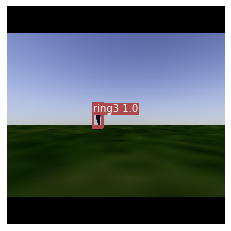

(0) Image
	+ Label: ring3, Conf: 0.99570
	+ Label: ring3, Conf: 0.99782
	+ Label: ring3, Conf: 0.99915


<Figure size 432x288 with 0 Axes>

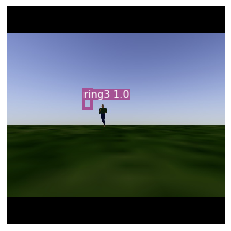

(1) Image
	+ Label: ring3, Conf: 0.98099
	+ Label: ring3, Conf: 0.98900
	+ Label: ring3, Conf: 0.97990


<Figure size 432x288 with 0 Axes>

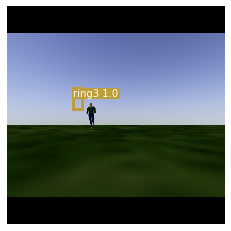

(2) Image
	+ Label: ring1, Conf: 0.97095
	+ Label: ring1, Conf: 0.70630


<Figure size 432x288 with 0 Axes>

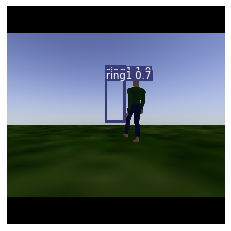

(3) Image
	+ Label: ring2, Conf: 0.87268
	+ Label: ring2, Conf: 0.84384


<Figure size 432x288 with 0 Axes>

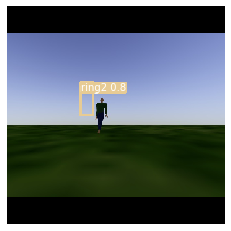

(4) Image
	+ Label: ring1, Conf: 0.99897
	+ Label: ring1, Conf: 0.91299


<Figure size 432x288 with 0 Axes>

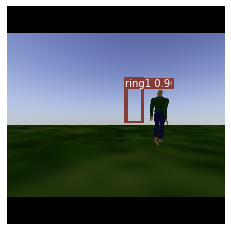

(5) Image
	+ Label: ring3, Conf: 0.99925
	+ Label: ring3, Conf: 0.99969


<Figure size 432x288 with 0 Axes>

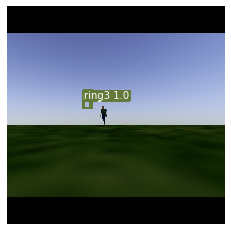

(6) Image
	+ Label: ring3, Conf: 0.99611


<Figure size 432x288 with 0 Axes>

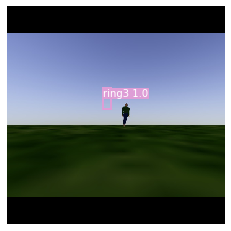

(7) Image
	+ Label: ring2, Conf: 0.94884
	+ Label: ring3, Conf: 0.76581


<Figure size 432x288 with 0 Axes>

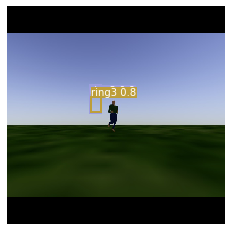

(8) Image
	+ Label: ring2, Conf: 0.98969


<Figure size 432x288 with 0 Axes>

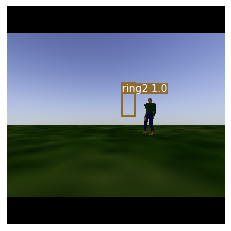

(9) Image
	+ Label: ring3, Conf: 0.99771


<Figure size 432x288 with 0 Axes>

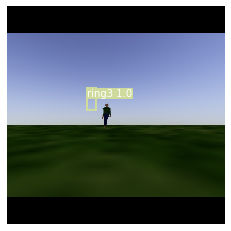

(10) Image
	+ Label: ring3, Conf: 0.98641
	+ Label: ring3, Conf: 0.99778


<Figure size 432x288 with 0 Axes>

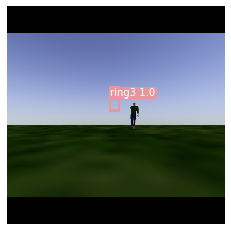

(11) Image
	+ Label: ring2, Conf: 0.99251


<Figure size 432x288 with 0 Axes>

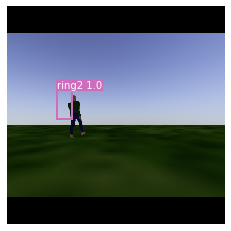

(12) Image
	+ Label: ring1, Conf: 0.99991
	+ Label: ring1, Conf: 0.98120


<Figure size 432x288 with 0 Axes>

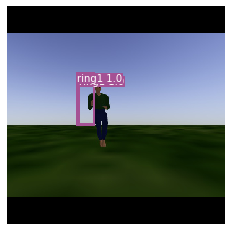

(13) Image
	+ Label: ring1, Conf: 0.92607
	+ Label: ring1, Conf: 0.93393
	+ Label: ring1, Conf: 0.87939


<Figure size 432x288 with 0 Axes>

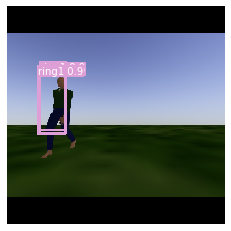

(14) Image
	+ Label: ring2, Conf: 0.92129
	+ Label: ring1, Conf: 0.60464


<Figure size 432x288 with 0 Axes>

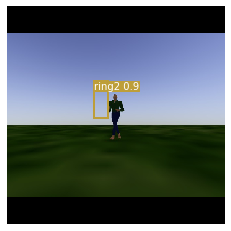

(15) Image
	+ Label: ring1, Conf: 0.99200
	+ Label: ring1, Conf: 0.78566


<Figure size 432x288 with 0 Axes>

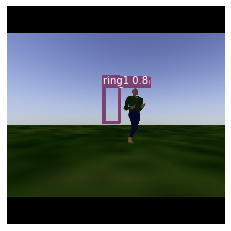

(0) Image
	+ Label: ring2, Conf: 0.96401
	+ Label: ring2, Conf: 0.95713


<Figure size 432x288 with 0 Axes>

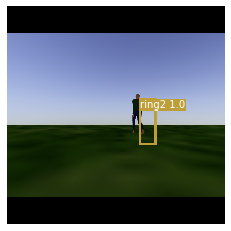

(1) Image
	+ Label: ring2, Conf: 0.76848
	+ Label: ring2, Conf: 0.74477


<Figure size 432x288 with 0 Axes>

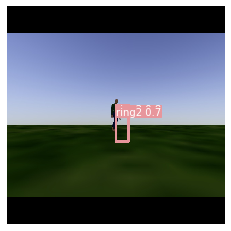

(2) Image
	+ Label: ring3, Conf: 0.71375
	+ Label: ring3, Conf: 0.54057


<Figure size 432x288 with 0 Axes>

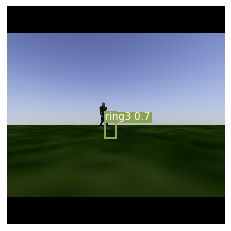

(3) Image
	+ Label: ring0, Conf: 0.95442
	+ Label: ring0, Conf: 0.97958


<Figure size 432x288 with 0 Axes>

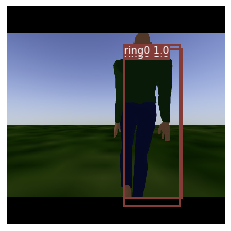

(4) Image
	+ Label: ring2, Conf: 0.88125
	+ Label: ring2, Conf: 0.75379


<Figure size 432x288 with 0 Axes>

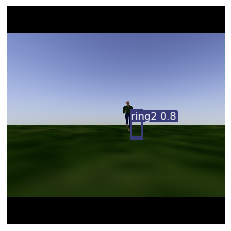

(5) Image
	+ Label: ring3, Conf: 0.65583
	+ Label: ring3, Conf: 0.53150


<Figure size 432x288 with 0 Axes>

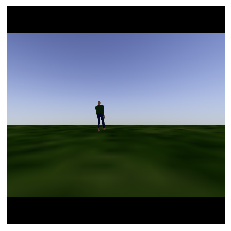

(6) Image
	+ Label: ring3, Conf: 0.99314
	+ Label: ring3, Conf: 0.99317
	+ Label: ring3, Conf: 0.95936


<Figure size 432x288 with 0 Axes>

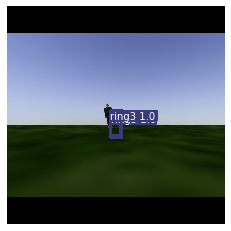

(7) Image
	+ Label: ring1, Conf: 0.99237
	+ Label: ring1, Conf: 0.65731


<Figure size 432x288 with 0 Axes>

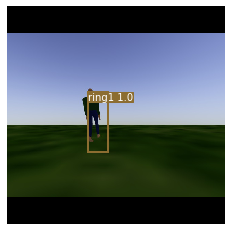

(8) Image
	+ Label: ring3, Conf: 0.71241
	+ Label: ring2, Conf: 0.59741


<Figure size 432x288 with 0 Axes>

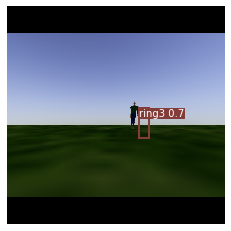

(9) Image
	+ Label: ring2, Conf: 0.94624
	+ Label: ring1, Conf: 0.72986


<Figure size 432x288 with 0 Axes>

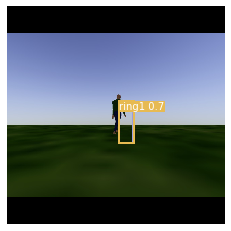

(10) Image
	+ Label: ring1, Conf: 0.97041
	+ Label: ring1, Conf: 0.96991


<Figure size 432x288 with 0 Axes>

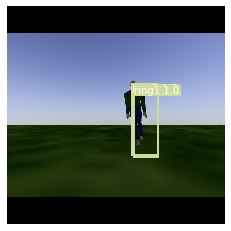

(11) Image
	+ Label: ring2, Conf: 0.97259


<Figure size 432x288 with 0 Axes>

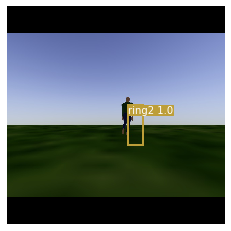

(12) Image
	+ Label: ring3, Conf: 0.75606
	+ Label: ring3, Conf: 0.38649


<Figure size 432x288 with 0 Axes>

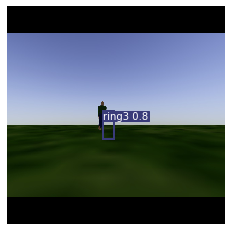

(13) Image
	+ Label: ring2, Conf: 0.88798
	+ Label: ring2, Conf: 0.84828


<Figure size 432x288 with 0 Axes>

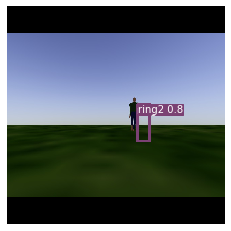

(14) Image
	+ Label: ring3, Conf: 0.63544
	+ Label: ring3, Conf: 0.58468


<Figure size 432x288 with 0 Axes>

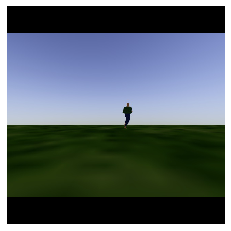

(15) Image
	+ Label: ring2, Conf: 0.94850


<Figure size 432x288 with 0 Axes>

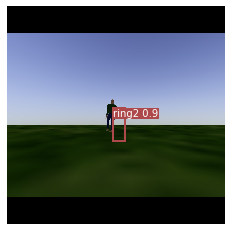

(0) Image
	+ Label: ring1, Conf: 0.99832
	+ Label: ring1, Conf: 0.92097


<Figure size 432x288 with 0 Axes>

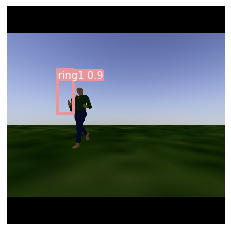

(1) Image
	+ Label: ring3, Conf: 0.99950
	+ Label: ring3, Conf: 0.99916


<Figure size 432x288 with 0 Axes>

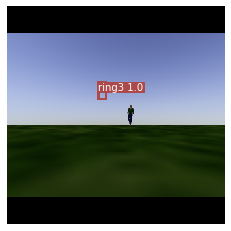

(2) Image
	+ Label: ring2, Conf: 0.93080
	+ Label: ring2, Conf: 0.50891


<Figure size 432x288 with 0 Axes>

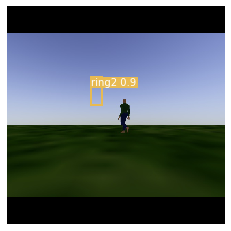

(3) Image
	+ Label: ring2, Conf: 0.80764
	+ Label: ring3, Conf: 0.76865


<Figure size 432x288 with 0 Axes>

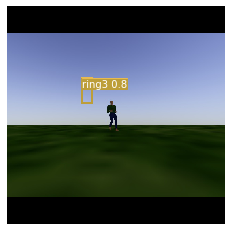

(4) Image
	+ Label: ring0, Conf: 0.96283
	+ Label: ring0, Conf: 0.97741


<Figure size 432x288 with 0 Axes>

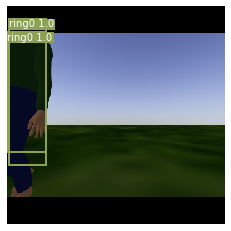

(5) Image
	+ Label: ring3, Conf: 0.99927
	+ Label: ring3, Conf: 0.99936


<Figure size 432x288 with 0 Axes>

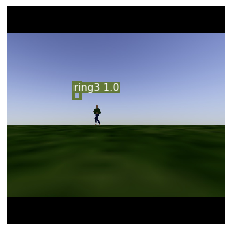

(6) Image
	+ Label: ring1, Conf: 0.81222
	+ Label: ring1, Conf: 0.40340


<Figure size 432x288 with 0 Axes>

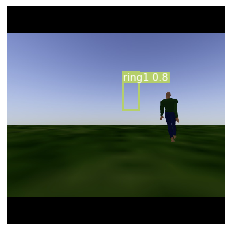

(7) Image
	+ Label: ring2, Conf: 0.96610
	+ Label: ring2, Conf: 0.91600


<Figure size 432x288 with 0 Axes>

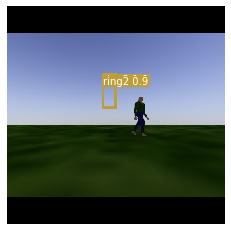

(8) Image
	+ Label: ring3, Conf: 0.99954
	+ Label: ring3, Conf: 0.99861


<Figure size 432x288 with 0 Axes>

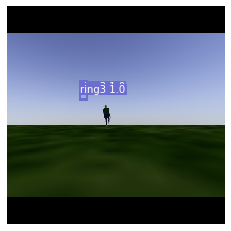

(9) Image
	+ Label: ring3, Conf: 0.87089
	+ Label: ring3, Conf: 0.63289


<Figure size 432x288 with 0 Axes>

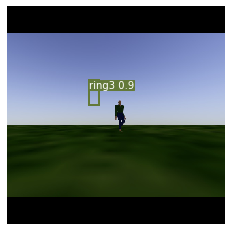

(10) Image
	+ Label: ring3, Conf: 0.98601
	+ Label: ring3, Conf: 0.99642


<Figure size 432x288 with 0 Axes>

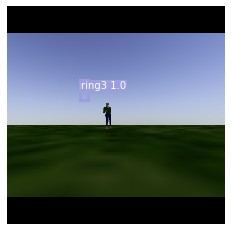

(11) Image
	+ Label: ring2, Conf: 0.92862
	+ Label: ring2, Conf: 0.72093


<Figure size 432x288 with 0 Axes>

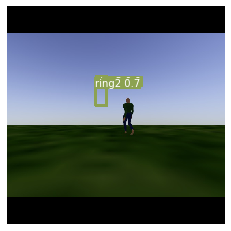

(12) Image
	+ Label: ring2, Conf: 0.98832


<Figure size 432x288 with 0 Axes>

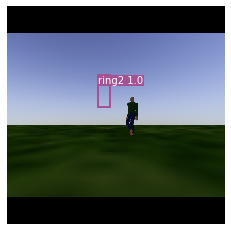

(13) Image
	+ Label: ring3, Conf: 0.99974
	+ Label: ring3, Conf: 0.99959


<Figure size 432x288 with 0 Axes>

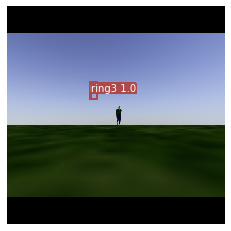

(14) Image


<Figure size 432x288 with 0 Axes>

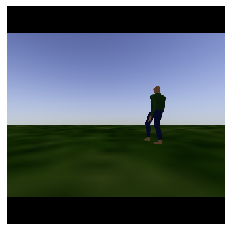

(15) Image
	+ Label: ring3, Conf: 0.93962
	+ Label: ring3, Conf: 0.91919


<Figure size 432x288 with 0 Axes>

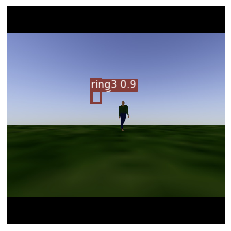

(0) Image
	+ Label: ring2, Conf: 0.89919
	+ Label: ring2, Conf: 0.77911


<Figure size 432x288 with 0 Axes>

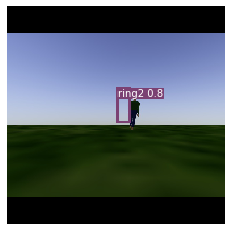

(1) Image
	+ Label: ring2, Conf: 0.93001


<Figure size 432x288 with 0 Axes>

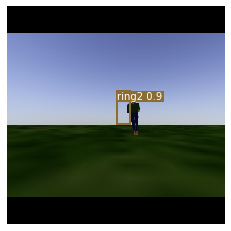

(2) Image
	+ Label: ring2, Conf: 0.83525
	+ Label: ring1, Conf: 0.49057


<Figure size 432x288 with 0 Axes>

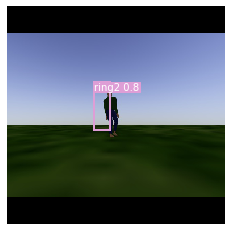

(3) Image


<Figure size 432x288 with 0 Axes>

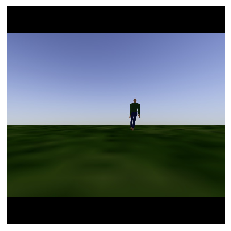

(4) Image
	+ Label: ring3, Conf: 0.99586
	+ Label: ring3, Conf: 0.99269


<Figure size 432x288 with 0 Axes>

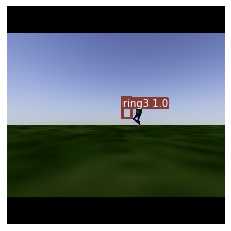

(5) Image
	+ Label: ring3, Conf: 0.98544
	+ Label: ring3, Conf: 0.95194


<Figure size 432x288 with 0 Axes>

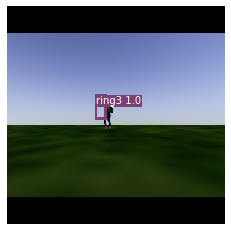

(6) Image
	+ Label: ring3, Conf: 0.98018
	+ Label: ring3, Conf: 0.73243


<Figure size 432x288 with 0 Axes>

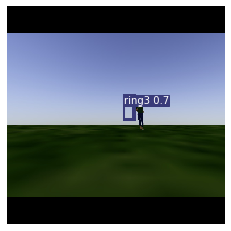

(7) Image
	+ Label: ring3, Conf: 0.99957
	+ Label: ring3, Conf: 0.99889


<Figure size 432x288 with 0 Axes>

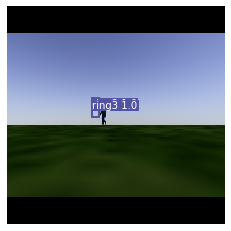

(8) Image
	+ Label: ring1, Conf: 0.99909


<Figure size 432x288 with 0 Axes>

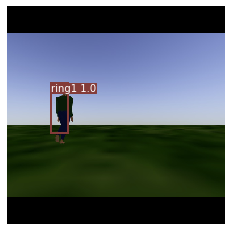

(9) Image
	+ Label: ring1, Conf: 0.98810
	+ Label: ring1, Conf: 0.25439


<Figure size 432x288 with 0 Axes>

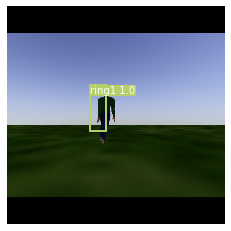

(10) Image
	+ Label: ring3, Conf: 0.89224
	+ Label: ring3, Conf: 0.79686


<Figure size 432x288 with 0 Axes>

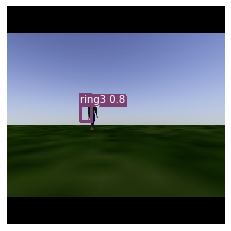

(11) Image
	+ Label: ring3, Conf: 0.82489
	+ Label: ring3, Conf: 0.63582


<Figure size 432x288 with 0 Axes>

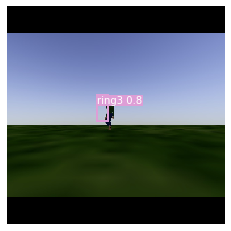

(12) Image
	+ Label: ring1, Conf: 0.99646
	+ Label: ring1, Conf: 0.92924


<Figure size 432x288 with 0 Axes>

In [ ]:
for j in range(10):
    plot_results(j)

In [17]:
c

3